# Dimensionality Reduction

We have more or less exhausted the basics of customizing a fully-connected feedforward neural network. We know how to do lots of things that are important. We can:

* Normalize the data
* Initialize the weights and biases
* Customize network architectures
* Use several activation functions
* Learn with gradient descent (or better, SGD) and backpropagation
* Modify SGD with momentum and other methods
* Use several loss functions
* Apply regularization methods

With all of this, we can make them quite good at some tasks, such as identifying handwritten digits from the MNIST dataset, by using carefully tuning the hyperparameters.

Harder problems, like classifying images from the CIFAR-10 dataset, are still a challenge. Classification accuracy using these neural nets is significantly better on this dataset (about 55% accuracy) than simplistic methods like nearest neighbors (about 25% accuracy). However, 55% accuracy is not very reliable practically.

There are a number of options that might help:

* Use deeper networks
* Use wider networks
* Use higher dimensional data

All of these options have something in common: they are computationally expensive due to the increasing dimensionality of the data and/or the weight matrices, so they are not particularly helpful options. A theme of the next portion of the class will be to try to manage this dimensionality problem.

## Principal Components Analysis (PCA)

Principal components analysis (PCA) is a method for reducing the dimension of the data by using some ideas from linear algebra to map the rows from a data matrix $X$ from its default $d$-dimensional space to an $r$-dimensional space for some $r < d$.

Please see the notes in class for the math that makes this work, but the code is below.

In [1]:
import numpy as np
import time

# Principal component analysis
def PCA(D, alpha):    
    print('[INFO] Now running principal components analysis (PCA)')
    
    # find the original dimension and print it
    dimension = D.shape[1]
    print('[INFO] The original dimension of the data is', dimension)
    
    # center D to have mean 0
    D -= np.mean(D, axis=0)
    
    # compute the covariance matrix
    Sigma = (1/D.shape[0]) * D.T @ D

    # compute the eigenvalues and eigenvectors of D^T D
    (eValues, eVectors) = np.linalg.eigh(Sigma)

    # compute the total variance
    varD = np.sum(eValues)
    
    # initialize the variance for A to 0
    varA = 0.0
    
    # reverse eValues and eVectors
    eValues = np.flip(eValues)
    eVectors = np.flip(eVectors, axis=1)

    # find the minimum dimension consisting of fraction at least alpha of the total variance
    for r in np.arange(0, eValues.shape[0]):
        varA += eValues[r]
        ratio = varA/varD

        if ratio > alpha:
            dimension = r + 1
            print('[INFO] The new dimension of the data is', dimension, 'and it explains', ratio, 'of the variance')
            break
            
    # construct the new basis
    basis = eVectors[:,:dimension]
    
    # create the datapoints in the new space
    A = D @ basis
    
    # return points
    return A

To test this out a bit, let's bring in our neural network code and our favorite dataset (MNIST), use PCA to reduce the dimension of MNIST, and then train the neural net to classify the lower-dimensional data.

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10

# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   annealing - a list specifying the annealing schedule for the learning rate
#     'none' - use a constant learning rate
#     ['step', k] - decay the learning rate to 0 at k evenly spaced times with identical steps
#     ['exp', k] - decay the learning rate exponentially alpha = alpha0(exp(-k*epoch))
#     ['inv', k] - decay the learning rate as alpha = alpha0/(1 + k*epoch)
#
#   lambda1 - L1 penalty coefficient (positive)
#
#   lambda2 - L2 penalty coefficient (positive)
#
#   batchSize - size of mini-batches for SGD
#
#   gamma - momentum coefficient (between 0 and 1)
#
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#
#   activations - string to choose which activation functions to use:
#     'sigmoid' - sigmoid function
#     'ReLU' - rectified linear unit
#     'ELU' - exponential linear unit
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, annealing = 'none', lambda1 = 0, lambda2 = 0, batchSize = 32, gamma = 0.0,
                 initialization = 'normal', activations = 'sigmoid', loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # annealing policy
        self.annealing = annealing
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # momentum parameter
        self.gamma = gamma
        
        # activation type
        self.activation = activations
        
        # loss function
        self.loss = loss
        
        # initialize the weights -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        if initialization[0] == 'normal':
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
            
        if initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
            
        if initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i+1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
            
        # LeCun, Glorot, and He initialization
        if initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
    # define the activation function
    def activate(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1 + np.exp(-x))

        if self.activation == 'ReLU':
            return x*(x >= 0)
        
        if self.activation == 'ELU':
            return x*(x >= 0) + 0.1*(np.exp(x) - 1)*(x < 0)
    
    # define the activation derivative (where x is the INPUT to activation function)
    def activationDerivative(self, x):
        if self.activation == 'sigmoid':
            return self.activate(x) * (1 - self.activate(x))
        
        if self.activation == 'ReLU':
            return x >= 0
        
        if self.activation == 'ELU':
            return 1*(x >= 0) + 0.1*np.exp(x)*(x < 0)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, valX, valY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        validationAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = LabelBinarizer().fit_transform(y)
        
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))
            
        alpha = self.alpha

        for epoch in np.arange(0,epochs):
            
            if self.annealing[0] == 'step':
                stepSize = self.alpha/self.annealing[1]
                if epochs > 0 and epoch % self.annealing[1] == 0:
                    alpha -= stepSize
                    print(alpha)
                
            elif self.annealing[0] == 'exp':
                alpha = self.alpha * np.exp(-self.annealing[1] * epoch)
                    
            elif self.annealing[0] == 'inv':
                alpha = self.alpha / (1 + self.annealing[1] * epoch)
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.activate(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    Z.append(net)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activationDerivative(Z[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activationDerivative(Z[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    gradient = (A[layer].T.dot(D[layer])
                                + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer])
                                + (self.lambda2 / numberOfExamples) * self.W[layer])
                    
                    v[layer] = self.gamma * v[layer] + alpha * gradient
                    self.W[layer] -= v[layer]
              
            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:

                # if we chose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(valX)
                    predictedY = predictedY.argmax(axis=1)
                    validationAccuracy = accuracy_score(valY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    validationAccuracies.append(validationAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    
                    loss = self.computeLoss(X,y)
                    losses.append(loss)
                    print("[INFO] epoch = {}, loss = {:.6f}, training accuracy = {:.6f}, validation accuracy = {:.6f}".format(epoch + 1, loss, trainAccuracy, validationAccuracy))
                    
                # otherwise, simply print the training loss
                else:
                    #losses.append(loss)
                    #print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))
                    print('[INFO] Epoch =', epoch + 1, 'of', epochs)

        # if we chose to print the performance, plot loss, training accuracy, and validation accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), validationAccuracies, label = 'Accuracy (validation)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activate(np.dot(p, self.W[layer]))
            
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
            
        # if there is an L1 penalty, compute it and add it to the loss
        if self.lambda1 != 0:
            # compute the L1 penalty 
            L1penalty = 0

            for layer in np.arange(0,len(self.W)):
                L1penalty += np.sum(np.abs(self.W[layer]))
        
            # add the L1 penalty to the loss
            loss = loss + (self.lambda1 / X.shape[0]) * L1penalty
            
        # if there is an L2 penalty, compute it and add it to the loss
        if self.lambda2 != 0:
            # compute the L2 penalty 
            L2penalty = 0

            for layer in np.arange(0,len(self.W)):
                L2penalty += np.sum(self.W[layer] ** 2)
        
            # add the L2 penalty to the loss
            loss = loss + (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

First, let's run it on 60000 MNIST images and compute the time. Later, we will compare it to using PCA and training the net on the resulting data.

In [402]:
numberOfImages = 60000

# The datapoints are in mnistData[0][0]
X = data[0][0][:numberOfImages].reshape([numberOfImages,28*28]).astype('float')

# Normalize the data
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:numberOfImages]

# randomly choose 75% of the data to be the traini(ng set and 25% for the validation set
(trainX, valX, trainY, valY) = train_test_split(X, Y, test_size = 0.25)

start = time.time()

# fit the model to the training data
print('[INFO] Now training the neural network')

model = FeedforwardNeuralNetwork([X.shape[1], 128, 10], 0.001, ['exp', 0.1], 20.0, 300.0, 64, 0.9,
                                 ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')

model.fit(trainX, trainY, valX, valY, 25, 1, False)

end = time.time()

print('[INFO] Neural network training is finished after', end - start, 'seconds')

# Compute the outputs and measure the accuracy on the train and validation sets
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print('[INFO] Training set accuracy is', accuracy_score(trainY, predictedY))

valY = LabelBinarizer().fit_transform(valY)
predictedY = model.predict(valX)
predictedY = predictedY.argmax(axis=1)
valY = valY.argmax(axis=1)
print('[INFO] Validation set accuracy is', accuracy_score(valY, predictedY))

[INFO] Now training the neural network
[INFO] Epoch = 1 of 25
[INFO] Epoch = 2 of 25
[INFO] Epoch = 3 of 25
[INFO] Epoch = 4 of 25
[INFO] Epoch = 5 of 25
[INFO] Epoch = 6 of 25
[INFO] Epoch = 7 of 25
[INFO] Epoch = 8 of 25
[INFO] Epoch = 9 of 25
[INFO] Epoch = 10 of 25
[INFO] Epoch = 11 of 25
[INFO] Epoch = 12 of 25
[INFO] Epoch = 13 of 25
[INFO] Epoch = 14 of 25
[INFO] Epoch = 15 of 25
[INFO] Epoch = 16 of 25
[INFO] Epoch = 17 of 25
[INFO] Epoch = 18 of 25
[INFO] Epoch = 19 of 25
[INFO] Epoch = 20 of 25
[INFO] Epoch = 21 of 25
[INFO] Epoch = 22 of 25
[INFO] Epoch = 23 of 25
[INFO] Epoch = 24 of 25
[INFO] Epoch = 25 of 25
[INFO] Neural network training is finished after 39.66689205169678 seconds
[INFO] Training set accuracy is 0.9955555555555555
[INFO] Validation set accuracy is 0.9816666666666667


We achieved 98% accuracy on the validation set and the run time was 40 seconds. Now, let's do exactly the same thing *except* we will use PCA to reduce the dimension of the same data before running the neural network.

In [405]:
numberOfImages = 60000

# The datapoints are in mnistData[0][0]
X = data[0][0][:numberOfImages].reshape([numberOfImages,28*28]).astype('float')

start = time.time()

# Apply PCA to the data matrix X
X = PCA(X, 0.8)

end = time.time()

print('[INFO] PCA finished in', end - start, 'seconds')

# Normalize the data
X = X/255.0

# The labels are in mnistData[0][1]
Y = data[0][1][:numberOfImages]

# randomly choose 75% of the data to be the training set and 25% for the validation set
(trainX, valX, trainY, valY) = train_test_split(X, Y, test_size = 0.25)

start = time.time()

# fit the model to the training data
print('[INFO] Now training the neural network')

model = FeedforwardNeuralNetwork([X.shape[1], 128, 10], 0.001, ['exp', 0.1], 20.0, 300.0, 64, 0.9,
                                 ['Glorot', 'uni
                                  form'], 'ReLU', 'cross-entropy')

model.fit(trainX, trainY, valX, valY, 25, 1, False)

end = time.time()

print('[INFO] Neural network training is finished after', end - start, 'seconds')

# Compute the outputs and measure the accuracy on the train and validation sets
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print('[INFO] Training set accuracy is', accuracy_score(trainY, predictedY))

valY = LabelBinarizer().fit_transform(valY)
predictedY = model.predict(valX)
predictedY = predictedY.argmax(axis=1)
valY = valY.argmax(axis=1)
print('[INFO] Validation set accuracy is', accuracy_score(valY, predictedY))

[INFO] Now running principal components analysis (PCA)
[INFO] The original dimension of the data is 784
[INFO] The new dimension of the data is 44 and it explains 0.80329075538368 of the variance
[INFO] PCA finished in 3.970233201980591 seconds
[INFO] Now training the neural network
[INFO] Epoch = 1 of 25
[INFO] Epoch = 2 of 25
[INFO] Epoch = 3 of 25
[INFO] Epoch = 4 of 25
[INFO] Epoch = 5 of 25
[INFO] Epoch = 6 of 25
[INFO] Epoch = 7 of 25
[INFO] Epoch = 8 of 25
[INFO] Epoch = 9 of 25
[INFO] Epoch = 10 of 25
[INFO] Epoch = 11 of 25
[INFO] Epoch = 12 of 25
[INFO] Epoch = 13 of 25
[INFO] Epoch = 14 of 25
[INFO] Epoch = 15 of 25
[INFO] Epoch = 16 of 25
[INFO] Epoch = 17 of 25
[INFO] Epoch = 18 of 25
[INFO] Epoch = 19 of 25
[INFO] Epoch = 20 of 25
[INFO] Epoch = 21 of 25
[INFO] Epoch = 22 of 25
[INFO] Epoch = 23 of 25
[INFO] Epoch = 24 of 25
[INFO] Epoch = 25 of 25
[INFO] Neural network training is finished after 6.0101847648620605 seconds
[INFO] Training set accuracy is 0.990377777777777

Here, requiring a number of dimensions explaining 80\% of the variance of the dataset with PCA reduced the dimension from 784 to 44, a reduction of over 94\%! What is even more amazing is that the training accuracy on the lower-dimensional data is still 98\%, but the time for PCA (4 seconds) + the time of training (6 seconds) is only 10 seconds, about 1/4 the time as without PCA.

Let's try it with CIFAR-10, since it was pretty intractable with a fully-connected feedforward neural network, so let's see if performance improves or at least stays the same when we use PCA.

First, without PCA.

[INFO] Now training the neural network


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:348: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:348: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.226987, validation accuracy = 0.227760
[INFO] epoch = 2, loss = inf, training accuracy = 0.255093, validation accuracy = 0.252720
[INFO] epoch = 3, loss = inf, training accuracy = 0.305200, validation accuracy = 0.300960
[INFO] epoch = 4, loss = inf, training accuracy = 0.308267, validation accuracy = 0.309360


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:348: RuntimeWarning: invalid value encountered in log


[INFO] epoch = 5, loss = inf, training accuracy = 0.322053, validation accuracy = 0.323840
[INFO] epoch = 6, loss = inf, training accuracy = 0.338027, validation accuracy = 0.333840
[INFO] epoch = 7, loss = inf, training accuracy = 0.326027, validation accuracy = 0.327760
[INFO] epoch = 8, loss = inf, training accuracy = 0.335973, validation accuracy = 0.333120
[INFO] epoch = 9, loss = inf, training accuracy = 0.336453, validation accuracy = 0.333520
[INFO] epoch = 10, loss = inf, training accuracy = 0.356187, validation accuracy = 0.354400
[INFO] epoch = 11, loss = inf, training accuracy = 0.359200, validation accuracy = 0.354000
[INFO] epoch = 12, loss = inf, training accuracy = 0.366827, validation accuracy = 0.358720
[INFO] epoch = 13, loss = inf, training accuracy = 0.373413, validation accuracy = 0.358080
[INFO] epoch = 14, loss = inf, training accuracy = 0.382667, validation accuracy = 0.368400
[INFO] epoch = 15, loss = inf, training accuracy = 0.382907, validation accuracy = 0.

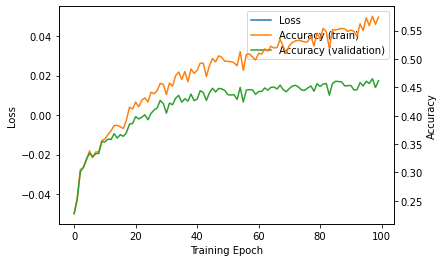

In [14]:
cifarData = cifar10.load_data()

numberOfImages = 50000

# The datapoints are in mnistData[0][0]
X = cifarData[0][0][:numberOfImages].reshape([numberOfImages,32*32*3]).astype('float')

# Normalize the data
X = X/255.0

# The labels are in mnistData[0][1]
Y = cifarData[0][1][:numberOfImages]

# randomly choose 75% of the data to be the training set and 25% for the validation set
(trainX, valX, trainY, valY) = train_test_split(X, Y, test_size = 0.25)

start = time.time()

# fit the model to the training data
print('[INFO] Now training the neural network')

#model = FeedforwardNeuralNetwork([X.shape[1], 128, 10], 0.001, ['exp', 0.1], 20.0, 300.0, 64, 0.9,
#                                 ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')

model = FeedforwardNeuralNetwork([X.shape[1], 64, 32, 16, 10], 0.001, 'none', 0.0, 0.0, 32, 0.0,
                                 ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')

model.fit(trainX, trainY, valX, valY, 100, 1)

end = time.time()

print('[INFO] Neural network training is finished after', end - start, 'seconds')

# Compute the outputs and measure the accuracy on the train and validation sets
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print('[INFO] Training set accuracy is', accuracy_score(trainY, predictedY))

valY = LabelBinarizer().fit_transform(valY)
predictedY = model.predict(valX)
predictedY = predictedY.argmax(axis=1)
valY = valY.argmax(axis=1)
print('[INFO] Validation set accuracy is', accuracy_score(valY, predictedY))

Next, let's use PCA to shrink the data to a lower dimension and see how the runtime and performance compare with all settings equal.

[INFO] Now running principal components analysis (PCA)
[INFO] The original dimension of the data is 3072
[INFO] The new dimension of the data is 99 and it explains 0.9003187633153611 of the variance
[INFO] PCA finished in 156.3903968334198 seconds
[INFO] Now training the neural network


C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:348: RuntimeWarning: divide by zero encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:348: RuntimeWarning: invalid value encountered in multiply
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:348: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\anaconda3\envs\DL\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[INFO] epoch = 1, loss = inf, training accuracy = 0.274720, validation accuracy = 0.275280
[INFO] epoch = 2, loss = inf, training accuracy = 0.311893, validation accuracy = 0.309680
[INFO] epoch = 3, loss = inf, training accuracy = 0.338987, validation accuracy = 0.331760
[INFO] epoch = 4, loss = inf, training accuracy = 0.357520, validation accuracy = 0.345280
[INFO] epoch = 5, loss = inf, training accuracy = 0.376400, validation accuracy = 0.362640
[INFO] epoch = 6, loss = inf, training accuracy = 0.391680, validation accuracy = 0.375520
[INFO] epoch = 7, loss = inf, training accuracy = 0.406347, validation accuracy = 0.389280
[INFO] epoch = 8, loss = inf, training accuracy = 0.415200, validation accuracy = 0.398640
[INFO] epoch = 9, loss = inf, training accuracy = 0.419680, validation accuracy = 0.397680
[INFO] epoch = 10, loss = inf, training accuracy = 0.430160, validation accuracy = 0.408400
[INFO] epoch = 11, loss = inf, training accuracy = 0.436613, validation accuracy = 0.4160

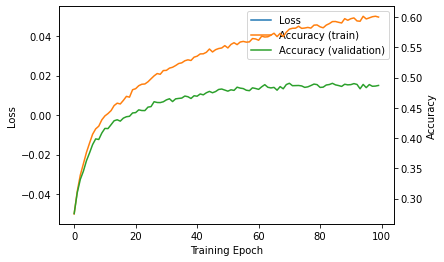

In [15]:
## cifarData = cifar10.load_data()

numberOfImages = 50000

# The datapoints are in mnistData[0][0]
X = cifarData[0][0][:numberOfImages].reshape([numberOfImages,32*32*3]).astype('float')

start = time.time()

# Apply PCA to the data matrix X
X = PCA(X, 0.9)

end = time.time()

print('[INFO] PCA finished in', end - start, 'seconds')

# Normalize the data
X = X/255.0

# The labels are in mnistData[0][1]
Y = cifarData[0][1][:numberOfImages]

# randomly choose 75% of the data to be the training set and 25% for the validation set
(trainX, valX, trainY, valY) = train_test_split(X, Y, test_size = 0.25)

start = time.time()

# fit the model to the training data
print('[INFO] Now training the neural network')

#model = FeedforwardNeuralNetwork([X.shape[1], 128, 10], 0.001, ['exp', 0.1], 20.0, 300.0, 64, 0.9,
#                                 ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')

model = FeedforwardNeuralNetwork([X.shape[1], 64, 32, 16, 10], 0.001, 'none', 0.0, 0.0, 32, 0.0,
                                 ['Glorot', 'uniform'], 'ReLU', 'cross-entropy')

model.fit(trainX, trainY, valX, valY, 100, 1)

end = time.time()

print('[INFO] Neural network training is finished after', end - start, 'seconds')

# Compute the outputs and measure the accuracy on the train and validation sets
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print('[INFO] Training set accuracy is', accuracy_score(trainY, predictedY))

valY = LabelBinarizer().fit_transform(valY)
predictedY = model.predict(valX)
predictedY = predictedY.argmax(axis=1)
valY = valY.argmax(axis=1)
print('[INFO] Validation set accuracy is', accuracy_score(valY, predictedY))

Performance is still not great, but it is better by 2.5% accuracy on the validation set. This is a huge win! Not only did we gain accuracy, but it took way less computation. This one took

* 156 seconds for PCA
* 77 seconds for training

or 233 total seconds while training with the original dataset took 1551 seconds.